In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import json
import random
import copy

from dsets import ClinicalDiseaseDataset, ClinicalMedicineDataset

/home/ubuntu/research-1/medical-gpt-interpretability/ENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")

In [6]:
with_context = False
disease_dataset = ClinicalDiseaseDataset('../data')
medicine_dataset = ClinicalMedicineDataset('../data')

Loaded dataset with 499 samples
Loaded dataset with 100 samples


In [20]:
disease_dataset[0], medicine_dataset[0]

({'category': 'Disease',
  'subjects': ['programmed cell death'],
  'prompt': 'Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death? the answer to the question is',
  'attribute': 'yes'},
 {'category': 'Medicine',
  'subjects': ['anticoagulation'],
  'prompt': 'Question: Therapeutic anticoagulation in the trauma patient: is it safe? the answer to the question is',
  'attribute': 'no'})

In [8]:
def get_answer_prob(prompt, answer):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    # Forward pass to get the logits
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # Extract logits at the last position (where answer starts)
    logits = outputs.logits[0, -1, :]  # Shape: [vocab_size]

    # Get token IDs for "Yes", "No", and "Maybe"
    yes_token_id = tokenizer(" Yes", add_special_tokens=False)["input_ids"][0]
    no_token_id = tokenizer(" No", add_special_tokens=False)["input_ids"][0]
    maybe_token_id = tokenizer(" Maybe", add_special_tokens=False)["input_ids"][0]

    # Extract logits for the specific tokens
    answer_logits = logits[[yes_token_id, no_token_id, maybe_token_id]]

    # Convert logits to probabilities
    answer_probs = F.softmax(answer_logits, dim=0)

    if answer == 'yes':
        return answer_probs[0].item()
    elif answer == 'no':
        return answer_probs[1].item()
    elif answer == 'maybe':
        return answer_probs[2].item()
    

In [23]:
def make_corrupt_prompt(data):
    clean_prompt = data['prompt']
    subject_arr = data['subjects']
    category = data['category']

    if category == 'Disease':
        contrast_dataset = medicine_dataset
    elif category == 'Medicine':
        contrast_dataset = disease_dataset
    else:
        raise ValueError('Invalid category')
    
    idx = random.randint(0, len(contrast_dataset) - 1)
    replacement_data = contrast_dataset[idx]
    new_subject = replacement_data['subjects'][0]
    
    corrupt_prompt = clean_prompt
    for subject in subject_arr:
        corrupt_prompt = corrupt_prompt.replace(subject, new_subject)
    
    return corrupt_prompt

In [24]:
def get_all_prob_diffs(category, runs=2):
    if category == 'disease':
        dataset = disease_dataset
    elif category == 'medicine':
        dataset = medicine_dataset
    else:
        raise ValueError('Invalid data type')

    prob_diffs = []
    for i in range(len(dataset)):
        cur_diff = 0.0
        for j in range(runs):
            data = dataset[i]
            clean_prompt = data['prompt']
            clean_prob = get_answer_prob(clean_prompt, data['attribute'])

            corrupted_prompt = make_corrupt_prompt(data)
            corrupted_prob = get_answer_prob(corrupted_prompt, data['attribute'])

            cur_diff += clean_prob - corrupted_prob
        prob_diffs.append(cur_diff / runs)
    return prob_diffs

In [25]:
num_runs = 1
results = []
diff_idx_lists = []

for i in range(num_runs):
    print(f'Run {i+1}')
    prob_diffs = get_all_prob_diffs('medicine')
    results.append(prob_diffs)

Run 1


In [26]:
def plot_histogram(data, title):
    plt.hist(data, bins=20)
    plt.title(title)
    plt.xlabel('Answer Token Probability Difference')
    plt.ylabel('Frequency')
    plt.show()

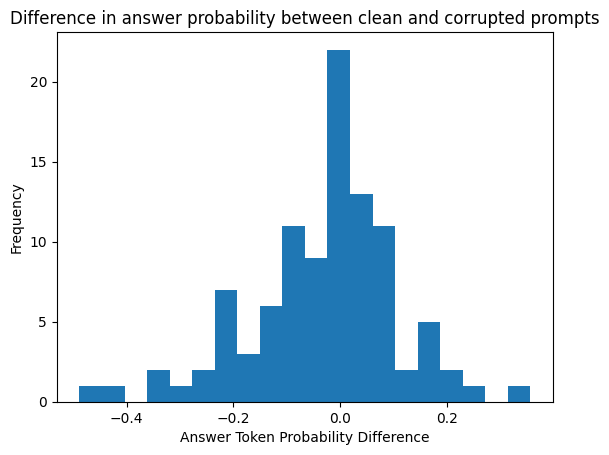

In [27]:
title = 'Difference in answer probability between clean and corrupted prompts'
if with_context:
    title += ' (with context)'
plot_histogram(prob_diffs, title)

In [13]:
# get the idx of samples that has near 0 difference
near_zero_diff_idx_first_run = [i for i, diff in enumerate(prob_diffs) if abs(diff) < 0.1]
print('near zero diff idx:', near_zero_diff_idx_first_run)

near zero diff idx: [1, 3, 4, 5, 10, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 56, 59, 60, 62, 63, 66, 67, 69, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 93, 96, 97, 99, 100, 101, 104, 105, 106, 107, 110, 113, 114, 116, 117, 118, 121, 126, 127, 129, 130, 132, 135, 136, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 155, 156, 157, 160, 162, 163, 164, 165, 166, 167, 168, 169, 173, 179, 180, 182, 183, 185, 186, 187, 190, 191, 193, 194, 195, 196, 197, 198, 199, 201, 204, 206, 208, 211, 213, 214, 215, 216, 220, 221, 222, 223, 225, 226, 227, 228, 230, 231, 232, 233, 236, 237, 238, 240, 241, 242, 244, 245, 247, 248, 250, 253, 257, 258, 259, 260, 262, 263, 264, 266, 267, 270, 272, 273, 274, 275, 276, 278, 280, 281, 283, 285, 286, 288, 290, 292, 293, 295, 298, 300, 301, 303, 308, 309, 311, 318, 320, 323, 326, 333, 336, 338, 340, 344, 346, 348, 350, 351, 356, 357, 359, 363, 364, 365, 366, 367, 3

In [16]:
# check overlaped idx between runs
common = set(diff_idx_lists[0])
for i in range(1, num_runs):
    common = common.intersection(diff_idx_lists[i])
print(len(common), 'samples have near zero difference in all runs')


170 samples have near zero difference in all runs


In [18]:
# save the common idx as a list of json, create a new file if not exist
with open('common_idx.json', 'w') as f:
    json.dump(list(common), f)
